Code used from Ben Moseley's PINN Tutorial [https://github.com/benmoseley/harmonic-oscillator-pinn/blob/main/Harmonic%20oscillator%20PINN.ipynb]



This project involves solving the 1D damped harmonic oscillator:

$$
\frac{d^2 x}{d t^2} + \mu \frac{d x}{d t} + kx = 0
$$

In the under-damped state:

$$
\delta < \omega_0 ~,~~~~~ \mathrm{with}~~\delta = \frac{\mu}{2m}~,~ \omega_0 = \sqrt{\frac{k}{m}}
$$

And the initial conditions:
$$ x(0) = 1~~,~~ \frac{d x}{d t} = 0~ $$

Which have the solutions: 
$$x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~ \mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}$$

First we will take a look at solving this problem with a standard neural network. Since this is a differential equation, the NN will only be able to interpolate a small part of the solution, using some observed training points from the solution.

Then we will take a look at using a Physics Informed Neural Network (PINN). We will train a PINN to extrapolate the full solutiuon by incorporating the differential equation in its loss function.


In [2]:
# Enviroment Setup

from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)


def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    
    try:
        assert d < w0
        w = np.sqrt(w0**2-d**2)
        phi = np.arctan(-d/w)
        A = 1/(2*np.cos(phi))
        cos = torch.cos(phi+w*x)
        sin = torch.sin(phi+w*x)
        exp = torch.exp(-d*x)
        y  = exp*2*A*cos
        return y
    except AssertionError:
        print("d > w_0 - aborting")
        exit()
    
# "FCN = Fully Connected Network"    
class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh # Activation function

        # Each one of these are our layers in our NN; Input parameters allow us to alter the NN.
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    # Defines how the input data travels through the NN
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

# Generate Training Data

For this problem, we use $ \delta = 2$, $ \omega_0 = 20 $ and try to learn the solution over the domain $x \in [0,1]$

Here's the visualization of the data we are providing the NN

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


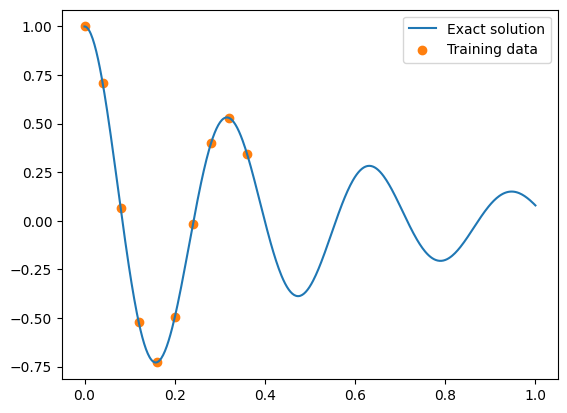

In [4]:
# Training Data parameters
d, w0 = 2, 20

# Get the analytical solution over full domain
x = torch.linspace(0,1,500).view(-1,1) # data between 0-1, reshaping it with the view function
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape) # [500, 1], [500, 1]

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

# Normal neural network

Next, we train a standard neural network (fully connected network) to fit these training points.

We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.

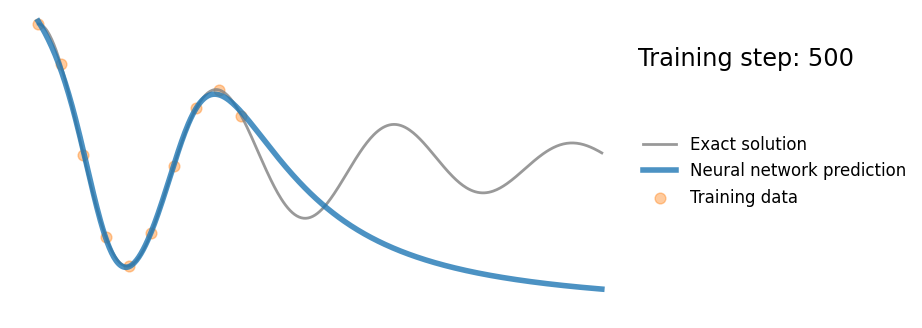

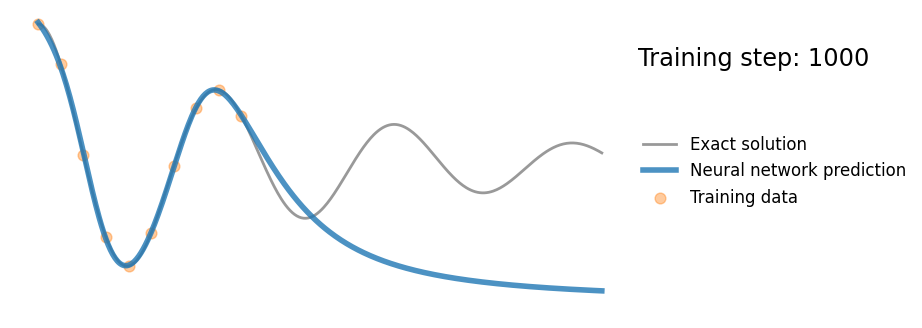

In [8]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")


# train standard neural network to fit training data
torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3) # What does this do
files = []

for i in range(1000):
    optimizer.zero_grad()   # What does this do
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()  # What does this do
    optimizer.step()  # What does this do
    
    
    # plot the result as training progresses
    if (i+1) % 100 == 0: 
        
        yh = model(x).detach()
        
        plot_result(x,y,x_data,y_data,yh)
        
        file = "plots/nn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (i+1) % 500 == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("nn.gif", files, fps=20, loop=0)

# PINN

Finally, we add the underlying differential equation ("physics loss") to the loss function.

The physics loss aims to ensure that the learned solution is consistent with the underlying differential equation. This is done by penalising the residual of the differential equation over a set of locations sampled from the domain.

Here we evaluate the physics loss at 30 points uniformly spaced over the problem domain 
. We can calculate the derivatives of the network solution with respect to its input variable at these points using pytorch's autodifferentiation features, and can then easily compute the residual of the differential equation using these quantities.


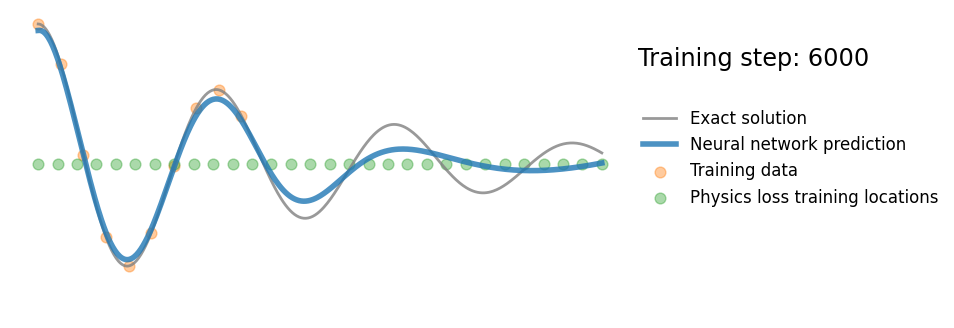

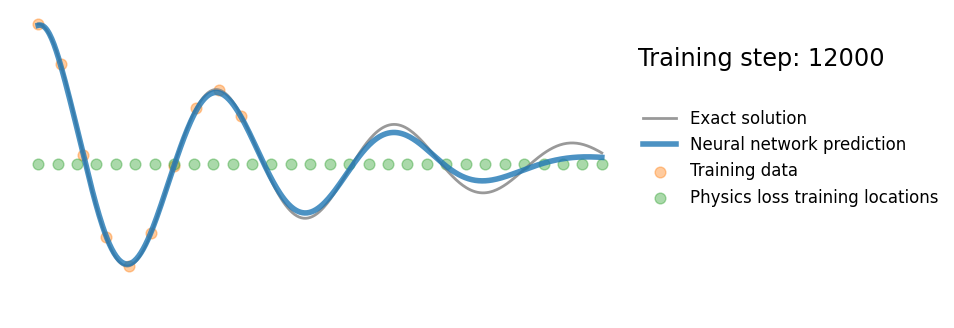

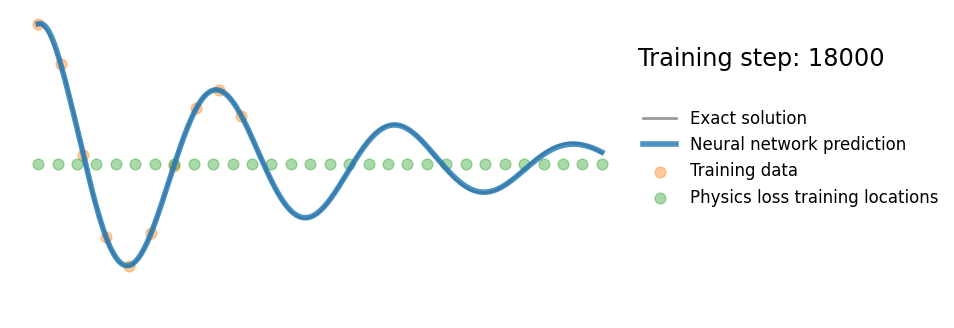

In [9]:
x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# sample locations over the problem domain
mu, k = 2*d, w0**2

torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []
for i in range(20000):
    optimizer.zero_grad()
    
    # compute the "data loss"
    yh = model(x_data)
    loss1 = torch.mean((yh-y_data)**2)# use mean squared error
    
    # compute the "physics loss" ; This is our second loss we are adding into the system
    # This one includes our residual in the loss
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + mu*dx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
    loss2 = (1e-4)*torch.mean(physics**2)
    
    # backpropagate joint loss 
    loss = loss1 + loss2# add two loss terms together
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 150 == 0: 
        
        yh = model(x).detach()
        xp = x_physics.detach()
        
        plot_result(x,y,x_data,y_data,yh,xp)
        
        file = "plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("pinn.gif", files, fps=20, loop=0)